In [52]:
## IMPORTS

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import math
from scipy import spatial
from scipy.spatial.distance import minkowski, cdist
from sklearn.metrics import mean_squared_error, mean_absolute_error
from decimal import Decimal

import seaborn as sns
from IPython.core import display as ICD

In [117]:
## Read in data

path = '/Users/ving2000/Downloads/CDS 403/Final_project/uci-restaurant-consumer-data/'

users = pd.read_csv('cleaned_userprofile.csv').set_index('userID')
usercuisine = pd.read_csv(os.path.join(path, 'usercuisine.csv'))

restaurants = pd.read_csv('cleaned_restaurants.csv')
rescuisine = pd.read_csv(os.path.join(path, 'chefmozcuisine.csv'))

ratings = pd.read_csv(os.path.join(path, 'rating_final.csv'))

In [3]:
df = pd.DataFrame(columns = restaurants['placeID'], index = users.index)
print('\n')
print('rows are customers')
print('columns are restaurants')
print('Fill in table with dot products', end = '\n\n')
ICD.display(df.head(7))


features = ['smoker', 'drink_level', 'dress_preference', 'ambience', 'budget']
rfeatures = ['smoking_area', 'alcohol', 'dress_code', 'Rambience', 'price']
fusers = users[features]
frestaurants = restaurants[rfeatures]



rows are customers
columns are restaurants
Fill in table with dot products



placeID,134999,132825,135106,132667,132613,135040,132732,132875,132609,135082,...,135028,135085,132663,132626,132583,132866,135072,135109,135019,132877
userID,,,,,,,,,,,,,,,,,,,,,
U1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U1002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U1004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U1005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U1006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U1007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
### Functions

def scale (x, df, lim = [0, 2]):
    """Scales ratings to range 0 - 2"""
    rmax = df.max().max()
    rmin = df.min().min()
    tmin, tmax = lim
    return (x - rmin)/(rmax - rmin) * (tmax - tmin) + tmin

def harvesine_dist(lat1, lon1, lat2, lon2):
    """ Calculates distance given 2 coordinates"""
    R = 6373.0 # approximate radius of earth in km
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

#----------------------------------------------------
## Similarity functions

def CalculateDot (s, user_array):
    """Calculates the dot product of 2 arrays"""
    arr = np.array(s)
    res = np.dot(arr, user_array)
    return res

def Jaccard(list1, list2):
    """Calculates Jaccard Similarity"""
    list1 = np.array(list1)
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

def Cosine(x,y):
    """Cosine Similarity"""
    x = np.array(x)
    result = 1 - spatial.distance.cosine(x, y)
    #result = cdist(x, y, 'cosine') 
    return result

#-----------------------------------------------------

def PredictRatings(df, restaurants, users, func):
    """Predicts rating using func
    df: empty ratings dataframe
    func: similary function
    """
    dff = df.copy()
    for user, row in dff.iterrows():
        user_feat = users.loc[user].to_numpy()
        dots = restaurants.apply(lambda x: func(x, user_feat), axis = 1).tolist()
        dff.loc[user] = dots
    
    ## Scale
    scaled_df = dff.apply(lambda x: scale(x, dff, [0, 2])).astype(float).round(1)
    return scaled_df

def Recommend (ratings_df, users, restaurants, userID):
    """Recommends restaurants given user attributes
    ratings_df: ratings dataframe from the PredictRatings function
    """
    transport_lim = {'on foot': 4.00, 'public': 4.00, 'car owner': 72.45}
    ## Get userID from ratings df
    candidates = ratings_df.loc[userID].to_dict()
    ## Get userID from users df
    user_df = users.loc['U1001']
    ## userID's location
    ulat, ulong = user_df[:2].values
    transport = user_df['transport']
    loc_candidates = {}
    
    ## Loop thru restaurants for row userID in ratingsdf
    for restau in candidates.keys():
        ## Calculate distance for each restaurant
        rlat, rlong = restaurants[restaurants['placeID'] == restau][['latitude', 'longitude']].values[0]
        dist = harvesine_dist(ulat, ulong, rlat, rlong)
        #if dist <= transport_lim[transport]:
         #   loc_candidates[restau] = (candidates.get(restau), dist)
        
        ## loc_candidate is a dictionary: {restaurantID: (predicted rating, distance)}
        loc_candidates[restau] = (candidates.get(restau), dist)
        
    ## Sort loc_candidates by ratings and distance
    sorted_candidates = sorted(loc_candidates.items(), key = lambda x: (-x[1][0],x[1][1]))
    
    ## Only return the first 15 recommendations
    if len(sorted_candidates) > 15:
        sorted_candidates = sorted_candidates[:15]
    
    ## Retrieve restaurant info from restaurannt df given ID in order of sorted_candidates
    recoms = pd.DataFrame()
    for i in sorted_candidates:
        df = restaurants[restaurants['placeID'] == i[0]][['placeID', 'name']]
        df['predicted'] = i[1][0]
        df['distance'] = i[1][1]
        recoms = pd.concat((recoms, df), axis = 0)
    
    return recoms 

### Similarity functions

1. Dot product

In [5]:
## Add 1 to avoid multiplication by 0
dotrestaurants = frestaurants + 1
dotusers = fusers + 1

dff_dot = PredictRatings(df, dotrestaurants, dotusers, CalculateDot)
print('\n ---------------------------------------------------------\n') 
print('PREDICTED RATINGS USING THE DOT PRODUCT')
ICD.display(dff_dot.head(7))


 ---------------------------------------------------------

PREDICTED RATINGS USING THE DOT PRODUCT


placeID,134999,132825,135106,132667,132613,135040,132732,132875,132609,135082,...,135028,135085,132663,132626,132583,132866,135072,135109,135019,132877
userID,,,,,,,,,,,,,,,,,,,,,
U1001,0.7,0.6,1.0,0.6,0.9,1.0,0.6,1.2,0.2,0.7,...,0.9,0.7,0.6,0.7,0.6,0.7,0.7,0.5,0.6,0.6
U1002,0.6,0.5,0.9,0.5,0.8,0.8,0.5,1.0,0.2,0.6,...,0.8,0.6,0.5,0.6,0.5,0.6,0.6,0.4,0.5,0.5
U1003,0.9,0.8,1.4,0.8,1.1,1.3,0.8,1.5,0.5,0.9,...,1.2,0.9,0.8,0.9,0.8,0.9,0.9,0.9,0.8,0.8
U1004,0.7,0.6,1.0,0.6,0.9,1.0,0.6,1.2,0.2,0.7,...,0.9,0.7,0.6,0.7,0.6,0.7,0.7,0.5,0.6,0.6
U1005,0.7,0.6,1.0,0.6,0.9,1.0,0.6,1.2,0.2,0.7,...,0.9,0.7,0.6,0.7,0.6,0.7,0.7,0.5,0.6,0.6
U1006,1.0,0.9,1.7,0.9,1.4,1.5,0.9,1.8,0.6,1.0,...,1.4,1.0,0.9,1.0,0.9,1.0,1.0,1.0,0.9,0.9
U1007,0.4,0.3,0.9,0.3,0.6,0.8,0.3,1.0,0.2,0.4,...,0.8,0.4,0.3,0.4,0.3,0.4,0.4,0.6,0.3,0.3


2. Jaccard Similarity

In [6]:
dff_jaccard = PredictRatings(df, frestaurants, fusers, Jaccard)
print('PREDICTED RATINGS USING JACCARD SIMILARITY')
ICD.display(dff_jaccard.head(7))

PREDICTED RATINGS USING JACCARD SIMILARITY


placeID,134999,132825,135106,132667,132613,135040,132732,132875,132609,135082,...,135028,135085,132663,132626,132583,132866,135072,135109,135019,132877
userID,,,,,,,,,,,,,,,,,,,,,
U1001,2.0,1.2,2.0,1.2,2.0,1.2,1.2,1.2,0.5,2.0,...,2.0,2.0,1.2,2.0,1.2,2.0,2.0,2.0,1.2,1.2
U1002,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,0.5,1.2,...,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2
U1003,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,0.5,1.2,...,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2
U1004,2.0,1.2,2.0,1.2,2.0,1.2,1.2,1.2,0.5,2.0,...,2.0,2.0,1.2,2.0,1.2,2.0,2.0,2.0,1.2,1.2
U1005,2.0,1.2,2.0,1.2,2.0,1.2,1.2,1.2,0.5,2.0,...,2.0,2.0,1.2,2.0,1.2,2.0,2.0,2.0,1.2,1.2
U1006,2.0,1.2,2.0,1.2,2.0,1.2,1.2,1.2,0.5,2.0,...,2.0,2.0,1.2,2.0,1.2,2.0,2.0,2.0,1.2,1.2
U1007,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,0.5,1.2,...,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2


3. Cosine similarity

In [70]:
import warnings
warnings.filterwarnings('ignore')

print('PREDICTED RATINGS USING COSINE SIMILARITY')
dff_cosine = PredictRatings(df, frestaurants, fusers, Cosine)
dff_cosine.head(7)

PREDICTED RATINGS USING COSINE SIMILARITY


placeID,134999,132825,135106,132667,132613,135040,132732,132875,132609,135082,...,135028,135085,132663,132626,132583,132866,135072,135109,135019,132877
userID,,,,,,,,,,,,,,,,,,,,,
U1001,2.0,1.8,1.2,1.8,1.5,1.5,1.8,1.3,NaN,2.0,...,1.5,2.0,1.8,2.0,1.8,2.0,2.0,0.4,1.8,1.8
U1002,1.8,2.0,1.1,2.0,1.3,1.2,2.0,1.0,NaN,1.8,...,1.3,1.8,2.0,1.8,2.0,1.8,1.8,0.0,2.0,2.0
U1003,1.0,1.2,1.3,1.2,0.8,1.3,1.2,1.2,NaN,1.0,...,1.5,1.0,1.2,1.0,1.2,1.0,1.0,1.0,1.2,1.2
U1004,2.0,1.8,1.2,1.8,1.5,1.5,1.8,1.3,NaN,2.0,...,1.5,2.0,1.8,2.0,1.8,2.0,2.0,0.4,1.8,1.8
U1005,2.0,1.8,1.2,1.8,1.5,1.5,1.8,1.3,NaN,2.0,...,1.5,2.0,1.8,2.0,1.8,2.0,2.0,0.4,1.8,1.8
U1006,1.2,1.1,2.0,1.1,1.7,1.6,1.1,1.9,NaN,1.2,...,1.7,1.2,1.1,1.2,1.1,1.2,1.2,1.2,1.1,1.1
U1007,0.0,0.0,1.1,0.0,0.0,1.2,0.0,1.0,NaN,0.0,...,1.3,0.0,0.0,0.0,0.0,0.0,0.0,1.8,0.0,0.0


4. Minkowski

In [113]:
def nth_root (value, n_root):
    root_value = 1/float(n_root)
    return round(Decimal(value) ** Decimal(root_value), 3)
def Minkowski (x, y, p_value=2):
    return nth_root(sum(pow(abs(a-b), p_value) for a, b in zip(x, y)), p_value)

<br><br>
### Evaluate Model

In [9]:
def GetPred (actual_df, pred_df):
    """Retrieve predictions from actual_df"""
    predictions = []
    for i, row in actual_df.iterrows():
        user = row['userID']
        restau = row['placeID']
        pred = pred_df.loc[user, restau]
        predictions.append(pred)
    return predictions

def FindAcc (df, sim:str, printf = True):
    """Calculates mean absolute error
    df: contains actuals and predictions
    sim: similarity function ('dot', 'jaccard', 'cosine')
    printf: print message, error cannot be stored in a var
    """
    
    actual = df['rating'].tolist()
    pred = df[sim].tolist()
    error = mean_absolute_error(actual, pred)
    if printf:
        print(f'Mean Absolute Error for {sim}: {error}')
    else:
        return error
    
def FindAccByAtt (attributes, df, users, sim:str):
    """
    Calculate mean absolute error by user attributes
    attributes: list of attributes
    df: contains actuals and predictions
    users: users dataframe
    sim: similarity function
    """
    rows = []
    for attribute in attributes:
        vals = users[attribute].unique()
        gb = users.groupby(attribute)
        print(f'Mean Absolute Error for {sim} by attribute: {attribute}')

        for i in vals:
            ids = gb.get_group(i).index
            rdf = df[df['userID'].isin(ids)]
            error = FindAcc(rdf, sim, printf = False)
            rows.append([sim, attribute, i, error])
            print(f' {i}: {error}')
        print('\n')
    mae_df = pd.DataFrame(rows, columns = ['sim', 'att', 'val', 'mae'])
    return mae_df

In [10]:
acc_df = ratings.copy().drop(['food_rating', 'service_rating'], axis = 1)
acc_df['dot'] = GetPred(ratings, dff_dot)
acc_df['jaccard'] = GetPred(ratings, dff_jaccard)
acc_df['cosine'] = GetPred(ratings, dff_cosine)
acc_df['cosine'].fillna(0, inplace = True)
acc_df.head(10)

,userID,placeID,rating,dot,jaccard,cosine
0,U1077,135085,2,0.9,2.0,1.5
1,U1077,135038,2,1.0,2.0,1.1
2,U1077,132825,2,0.8,1.2,1.3
3,U1077,135060,1,0.9,2.0,1.5
4,U1068,135104,1,1.1,1.2,1.9
5,U1068,132740,0,0.8,1.2,1.0
6,U1068,132663,1,0.7,1.2,1.4
7,U1068,132732,0,0.7,1.2,1.4
8,U1068,132630,1,0.7,1.2,1.4
9,U1067,132584,2,0.7,2.0,2.0


In [11]:
FindAcc(acc_df, 'dot')
FindAcc(acc_df, 'jaccard')
FindAcc(acc_df, 'cosine')

Mean Absolute Error for dot: 0.7217054263565892
Mean Absolute Error for jaccard: 0.6917312661498708
Mean Absolute Error for cosine: 0.7459086993970715


In [12]:
f = features.copy()
f.append('transport')
dot_mae = FindAccByAtt(f, acc_df, users, 'dot')

Mean Absolute Error for dot by attribute: smoker
 0: 0.7446695095948828
 1: 0.6251121076233184


Mean Absolute Error for dot by attribute: drink_level
 0: 0.7403508771929824
 1: 0.7119422572178478


Mean Absolute Error for dot by attribute: dress_preference
 0: 0.7316645807259072
 1: 0.6997237569060774


Mean Absolute Error for dot by attribute: ambience
 1: 0.7129807692307693
 0: 0.7966942148760331


Mean Absolute Error for dot by attribute: budget
 0.5: 0.7232876712328766
 0.0: 0.7063291139240506
 1.0: 0.8071428571428573


Mean Absolute Error for dot by attribute: transport
 0: 0.7195754716981133
 1: 0.7274760383386581




In [13]:
cosine_mae = FindAccByAtt(f, acc_df, users, 'cosine')

Mean Absolute Error for cosine by attribute: smoker
 0: 0.7705756929637526
 1: 0.6421524663677131


Mean Absolute Error for cosine by attribute: drink_level
 0: 0.768421052631579
 1: 0.7341207349081366


Mean Absolute Error for cosine by attribute: dress_preference
 0: 0.7545682102628286
 1: 0.7267955801104972


Mean Absolute Error for cosine by attribute: ambience
 1: 0.7215384615384615
 0: 0.9553719008264463


Mean Absolute Error for cosine by attribute: budget
 0.5: 0.728642590286426
 0.0: 0.7943037974683544
 1.0: 0.7119047619047618


Mean Absolute Error for cosine by attribute: transport
 0: 0.7726415094339621
 1: 0.673482428115016




In [14]:
jaccard_mae = FindAccByAtt(f, acc_df, users, 'jaccard')

Mean Absolute Error for jaccard by attribute: smoker
 0: 0.7062899786780383
 1: 0.630493273542601


Mean Absolute Error for jaccard by attribute: drink_level
 0: 0.6907268170426065
 1: 0.6922572178477691


Mean Absolute Error for jaccard by attribute: dress_preference
 0: 0.6972465581977471
 1: 0.6795580110497238


Mean Absolute Error for jaccard by attribute: ambience
 1: 0.6872115384615384
 0: 0.7305785123966941


Mean Absolute Error for jaccard by attribute: budget
 0.5: 0.711706102117061
 0.0: 0.6458860759493672
 1.0: 0.6547619047619048


Mean Absolute Error for jaccard by attribute: transport
 0: 0.7003537735849056
 1: 0.668370607028754




In [15]:
mae_df = pd.concat((dot_mae, cosine_mae, jaccard_mae), axis = 0)
mae_df['val'] = mae_df['val'].astype('category')
mae_df.head(20)

,sim,att,val,mae
0,dot,smoker,0.0,0.744670
1,dot,smoker,1.0,0.625112
2,dot,drink_level,0.0,0.740351
3,dot,drink_level,1.0,0.711942
4,dot,dress_preference,0.0,0.731665
5,dot,dress_preference,1.0,0.699724
6,dot,ambience,1.0,0.712981
7,dot,ambience,0.0,0.796694
8,dot,budget,0.5,0.723288
9,dot,budget,0.0,0.706329


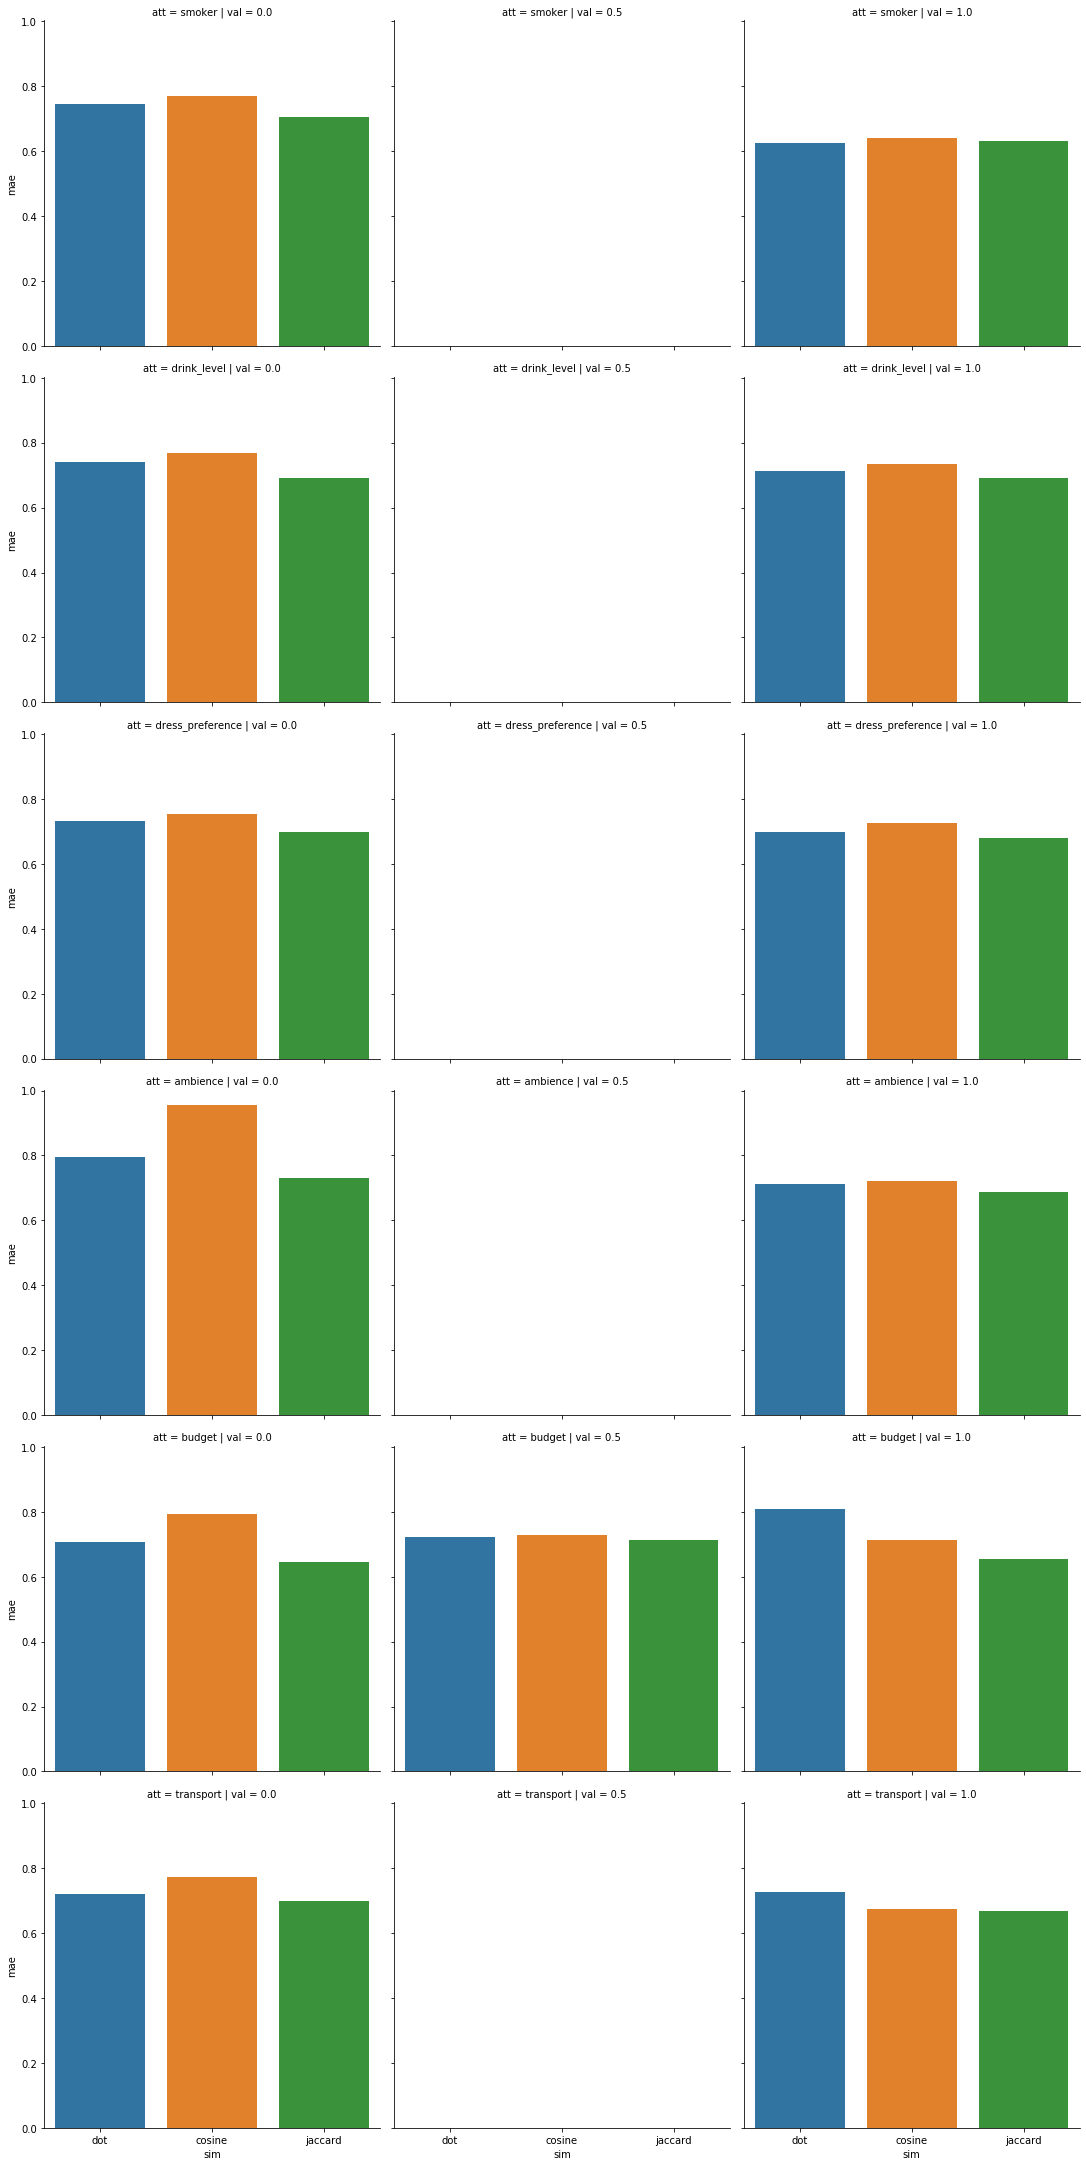

In [46]:
sns.catplot('sim', 'mae', col = 'val', row = 'att', kind = 'bar', data = mae_df, legend = True)

<br> <br> <br>

## Assign weights

In [72]:
np.average([1, np.nan, 3], weights = [0, 0, 1])

nan

In [133]:
def CombineSimFuncs (df, restaurants, users, weights = None):
    """ Calculates weighted average 
    weights = [dot, jaccard, cosine]"""
    
    dff_dot = PredictRatings(df, restaurants+1, users+1, CalculateDot)
    dff_jaccard = PredictRatings(df, restaurants, users, Jaccard)
    dff_cosine = PredictRatings(df, restaurants, users, Cosine)
    #### !!!!!!!!!
    dff_cosine.fillna(0, inplace = True)
    ### !!!!!!!!!
   
    for i in range(len(df)):
        d = dff_dot.values[i]
        j = dff_jaccard.values[i]
        c = dff_cosine.values[i]
        
        ratings = [[d[n], j[n], c[n]] for n in range(len(d))]
        new = np.round(np.average(ratings, axis = 1, weights = weights))
        df.iloc[i] = new
        
    return df

In [134]:
com_df = CombineSimFuncs(df, frestaurants, fusers, weights = None)

In [135]:
acc_df['avg'] = GetPred(ratings, com_df)
FindAcc(acc_df, 'avg')

Mean Absolute Error for avg: 0.6718346253229974


In [132]:
## Tuning weights

weights_df = pd.DataFrame(columns=('dot', 'jaccard', 'cosine', 'MAE'))
acc_df2 = acc_df.copy()

i = 0
for w1 in range(4):
    for w2 in range(4):
        for w3 in range(4):

            if len(set((w1,w2,w3))) == 1: # skip if all weights are equal
                continue

            preds = CombineSimFuncs(df, frestaurants, fusers, weights = [w1, w2, w3])
            acc_df2['avg'] = GetPred(ratings, preds)
            mae = FindAcc(acc_df, 'avg', printf = False)

            weights_df.loc[i] = [w1, w2, w3, mae]
            i += 1

weights_df.sort_values(['MAE'], ascending=True)

,dot,jaccard,cosine,MAE
0,0.0,0.0,1.0,0.687511
32,2.0,0.0,2.0,0.687511
33,2.0,0.0,3.0,0.687511
34,2.0,1.0,0.0,0.687511
35,2.0,1.0,1.0,0.687511
36,2.0,1.0,2.0,0.687511
37,2.0,1.0,3.0,0.687511
38,2.0,2.0,0.0,0.687511
39,2.0,2.0,1.0,0.687511
40,2.0,2.0,3.0,0.687511


In [136]:
Recommend(dff_jaccard, users, restaurants, 'U1001')

,placeID,name,predicted,distance
20,135033,Restaurant El Muladar de Calzada,2.0,37.125819
97,135027,Restaurant Orizatlan,2.0,53.027520
34,135025,El Rincon de San Francisco,2.0,61.106883
2,135106,El Rincón de San Francisco,2.0,64.203670
120,135028,La Virreina,2.0,67.916576
40,135041,Luna Cafe,2.0,70.871584
121,135085,Tortas Locas Hipocampo,2.0,73.060320
95,132922,cafe punta del cielo,2.0,74.340119
47,135059,Restaurant Bar Hacienda los Martinez,2.0,75.117539
108,135075,Mariscos El Pescador,2.0,80.474515


In [137]:
Recommend(com_df, users, restaurants, 'U1001')

,placeID,name,predicted,distance
34,135025,El Rincon de San Francisco,2.0,61.106883
121,135085,Tortas Locas Hipocampo,2.0,73.060320
108,135075,Mariscos El Pescador,2.0,80.474515
113,135062,Restaurante El Cielo Potosino,2.0,87.360340
117,132754,Cabana Huasteca,2.0,89.277797
54,135060,Restaurante Marisco Sam,2.0,107.633090
49,135063,Restaurante Alhondiga,2.0,108.542657
77,135044,Restaurant Wu Zhuo Yi,2.0,118.254259
25,135042,Restaurant Oriental Express,2.0,127.962120
39,132954,la parroquia,2.0,142.328230


In [138]:
ratings[ratings['userID'] == 'U1001']

,userID,placeID,rating,food_rating,service_rating
215,U1001,132830,1,1,1
216,U1001,132825,2,2,1
688,U1001,135085,0,1,1
689,U1001,135040,1,1,1
690,U1001,135039,1,1,1
691,U1001,135045,1,1,1
692,U1001,135033,1,1,1
693,U1001,135025,2,2,2
694,U1001,135051,1,1,2


In [171]:
rcuisine = pd.get_dummies(rescuisine, columns = ['Rcuisine']).groupby('placeID', as_index = False).max()
ucuisine = pd.get_dummies(usercuisine, columns = ['Rcuisine']).groupby('userID', as_index = False).max()

In [172]:
rcuisine.head(10)

,placeID,Rcuisine_Afghan,Rcuisine_African,Rcuisine_American,Rcuisine_Armenian,Rcuisine_Asian,Rcuisine_Bagels,Rcuisine_Bakery,Rcuisine_Bar,Rcuisine_Bar_Pub_Brewery,...,Rcuisine_Soup,Rcuisine_Southern,Rcuisine_Southwestern,Rcuisine_Spanish,Rcuisine_Steaks,Rcuisine_Sushi,Rcuisine_Thai,Rcuisine_Turkish,Rcuisine_Vegetarian,Rcuisine_Vietnamese
0,132001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,132002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,132003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,132004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,132005,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,132006,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,132007,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,132008,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,132009,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,132010,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


https://sebastianraschka.com/Articles/2014_ensemble_classifier.html

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3377942/

==> 2.48 miles = 3.99 km

https://www.statista.com/statistics/659362/time-consumers-would-use-to-drive-to-a-place-to-eat-us/

==> 45 miles = 72.42 km 

public transportation
